# Homework 2 - IEEE Fraud Detection

For all parts below, answer all parts as shown in the Google document for Homework 2. Be sure to include both code that justifies your answer as well as text to answer the questions. We also ask that code be commented to make it easier to follow.

## Part 1 - Fraudulent vs Non-Fraudulent Transaction

# TODO: code and runtime results
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [291]:
# Taking all imports for processing
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import xgboost as xgb

from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler

### Loading train-data in dataframes
### Since Part 1 to 5 would only involve following fields
TransactionID, DeviceType, DeviceInfo, TransactionDT, TransactionAmt, ProductCD, card4, card6, P_emaildomain, R_emaildomain, addr1, addr2, dist1, dist2
### Loading above necessary fields into base dataframe

In [2]:
# loading train-data in dataframes
train_identity_df = pd.read_csv("../data/train_identity.csv")
train_transaction_df = pd.read_csv("../data/train_transaction.csv")
global_df = pd.merge(left=train_transaction_df, right=train_identity_df, left_on=["TransactionID"],
                                       right_on="TransactionID", how="left")
# Since Part 1 to 5 would only involve following fields
# TransactionID,DeviceType,DeviceInfo,TransactionDT,TransactionAmt,ProductCD,card4,card6,P_emaildomain,R_emaildomain,addr1,addr2,dist1,dist2
# Loading above necessary fields into base dataframe
# And performing EDA on these data
basic_fields_df = global_df[["TransactionID", "TransactionDT", "TransactionAmt",
                                              "ProductCD", "card4", "card6", "P_emaildomain", "R_emaildomain", 
                                              "addr1", "addr2", "dist1", "dist2", "isFraud", "DeviceType", "DeviceInfo"]]

In [4]:
fraudulent_df = basic_fields_df[basic_fields_df.isFraud == 1]
non_fraudulent_df = basic_fields_df[basic_fields_df.isFraud == 0]
rows_in_fraud = fraudulent_df.shape[0]
rows_in_non_fraud = non_fraudulent_df.shape[0]
total_rows = basic_fields_df.shape[0]
print("Fraudulent instances: {0} | Non Fraudulent instances: {1}".format(str(rows_in_fraud), str(rows_in_non_fraud)))

Fraudulent instances: 20663 | Non Fraudulent instances: 569877


### Citation:
1. https://stackoverflow.com/questions/41681693/pandas-isnull-sum-with-column-headers (to aggregate over nulls and get their frequency)

### [Part 1] Comparing nulls between fraudulent and non-fraudulent data-set ###

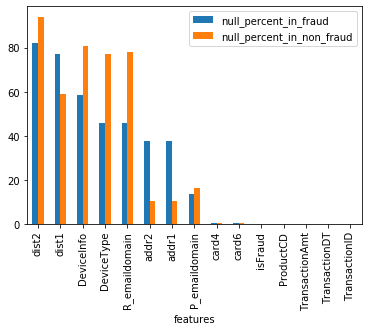

In [5]:
# isnull() returns boolean array for each row
# sum() on isnull() groups null values and take their sum returning a Series
# the Series returned has null value for each column (which can be seen as index for that value in Series)
# In the end, we take transpose() to convert index to column and corresponding row in Series to cell Value for that column
non_fraudulent_null_stats = non_fraudulent_df.isnull().sum().sort_values(ascending=False)
percent_non_fraud_nulls = non_fraudulent_null_stats * 100.0 / rows_in_non_fraud
percent_non_fraud_nulls = percent_non_fraud_nulls.reset_index()
percent_non_fraud_nulls = percent_non_fraud_nulls.rename(columns={'index': 'features', 0: 'null_percent'})

fraudulent_null_stats = fraudulent_df.isnull().sum().sort_values(ascending=False)
percent_fraud_nulls = fraudulent_null_stats * 100.0/ rows_in_fraud
percent_fraud_nulls = percent_fraud_nulls.reset_index()
percent_fraud_nulls = percent_fraud_nulls.rename(columns={'index': 'features', 0: 'null_percent'})

total_null_stats = pd.merge(percent_fraud_nulls, percent_non_fraud_nulls, on='features', suffixes=['_in_fraud', '_in_non_fraud'])

total_null_stats.plot.bar(x='features')

In [7]:
total_null_stats.head(20)

,features,null_percent_in_fraud,null_percent_in_non_fraud
0,dist2,81.943571,94.052050
1,dist1,76.987853,59.023789
2,DeviceInfo,58.345836,80.687236
3,DeviceType,45.743600,77.258426
4,R_emaildomain,45.666167,77.878735
5,addr2,37.463098,10.171493
6,addr1,37.463098,10.171493
7,P_emaildomain,13.502396,16.085225
8,card4,0.198422,0.269532
9,card6,0.188743,0.268830


### Observations ###
1. Just like the non-fraud transactions, majority of null values in fraud transactions are from distances, devices and email addresses.
2. The key difference is in the field of `DeviceInfo` (Windows/Mac OS), `DeviceType` (mobile, desktop), `R_emaildomain` (receipient email).
  
    a. For fraud transaction `null` values for DeviceInfo is around 58% of its set, whereas for non-fraud transactions its around 80%. 
  
    b. For fraud transaction `null` values for DeviceType is around 45% of its set, whereas for non-fraud transaction its around 77%.
  
    c. Also receipent email address are `null` for 45% of its set, whereas for non-fraud transaction its 77%.
  
  ### Conclusion (from visualization around null values in Fraud transactions and Non-Fraud transactions) ###
 One possible explanation for above discrepancy could be: the values for above details like email address are usually not provided or deferred by benevolent transactions, but a fraudster may have provided fake values instead of ignoring like a regular transactor. This in-turn reduced `null` values for fraud transactions.

### [Part 1] Exploring card-issuer field (card4) between fraudulent vs non-fraudluent transactions

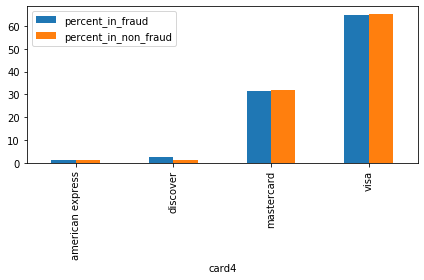

In [8]:
fraud_card_issuer_freq = fraudulent_df.card4.value_counts().sort_values(ascending=True)
fraud_card_issuer_freq = fraud_card_issuer_freq.rename_axis('card4').reset_index(name='freq')

non_fraud_card_issuer_freq = non_fraudulent_df.card4.value_counts().sort_values(ascending=True)
non_fraud_card_issuer_freq = non_fraud_card_issuer_freq.rename_axis('card4').reset_index(name='freq')

total_fraud_card_issuer_freq = fraud_card_issuer_freq.freq.sum()
total_non_fraud_card_issuer_freq = non_fraud_card_issuer_freq.freq.sum()

fraud_card_issuer_freq['percent'] = fraud_card_issuer_freq['freq'] * 100.0 / total_fraud_card_issuer_freq
non_fraud_card_issuer_freq['percent'] = non_fraud_card_issuer_freq['freq'] * 100.0 / total_non_fraud_card_issuer_freq

combined_card_issuer_freq = pd.merge(fraud_card_issuer_freq, non_fraud_card_issuer_freq, on='card4', how='outer', suffixes=['_in_fraud', '_in_non_fraud'])

combined_card_issuer_freq[['card4', 'percent_in_fraud', 'percent_in_non_fraud']].plot.bar(x='card4')
plt.tight_layout()

### Conclusion (card4):
1.  Except for minor bump for card-issuer 'discover' the usage for all types of card-issuers (american express, visa, etc.) is similar between fraudulent vs non-fraudulent transactions
2.  The minor bump in 'discover' category which is 2 % for fraud transactions vs 1 % for non-fraud transactions, may indicate that fraudster are twice as likely to use 'discover' than their non-fraudster counterparts

In [9]:
combined_card_issuer_freq

,card4,freq_in_fraud,percent_in_fraud,freq_in_non_fraud,percent_in_non_fraud
0,american express,239,1.158956,8089,1.423265
1,discover,514,2.492484,6137,1.079809
2,mastercard,6496,31.500339,182721,32.149889
3,visa,13373,64.848220,371394,65.347036


### [Part 1] Exploring card-type (card6 field) between fraudulent vs non-fraudulent transactions ###

In [10]:
fraud_card_freq = fraudulent_df.card6.value_counts().sort_values(ascending=True)
fraud_card_freq = fraud_card_freq.rename_axis("card6").reset_index(name="freq")

non_fraud_card_freq = non_fraudulent_df.card6.value_counts().sort_values(ascending=True)
non_fraud_card_freq = non_fraud_card_freq.rename_axis("card6").reset_index(name="freq")

total_non_fraud_freq = non_fraud_card_freq.freq.sum()
total_fraud_freq = fraud_card_freq.freq.sum()

fraud_card_freq['percent'] = fraud_card_freq['freq'] * 100.0 / total_fraud_freq
non_fraud_card_freq['percent'] = non_fraud_card_freq['freq'] * 100.0 / total_non_fraud_freq

combined_card_freq = pd.merge(fraud_card_freq[['card6', 'percent']], non_fraud_card_freq[['card6', 'percent']], on='card6', how='outer', suffixes=["_in_fraud", '_in_non_fraud'])
# Outer join results in NAN for non-existent values in opposite sets, so filling with 0, since we are dealing with percentages
combined_card_freq = combined_card_freq.fillna(0.0) 
combined_card_freq['percent_exp_fraud'] = np.cbrt(combined_card_freq['percent_in_fraud'])
combined_card_freq['percent_exp_non_fraud'] = np.cbrt(combined_card_freq['percent_in_non_fraud'])

combined_card_freq

,card6,percent_in_fraud,percent_in_non_fraud,percent_exp_fraud,percent_exp_non_fraud
0,credit,48.244763,24.463310,3.640408,2.902942
1,debit,51.755237,75.528772,3.726646,4.227051
2,charge card,0.000000,0.002639,0.000000,0.138195
3,debit or credit,0.000000,0.005278,0.000000,0.174115


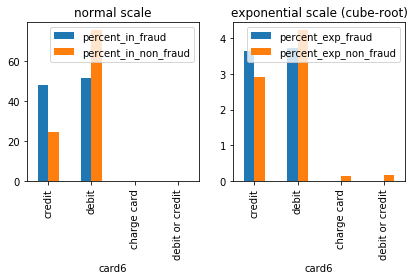

In [149]:
figures, axes = plt.subplots(1,2)
combined_card_freq.plot.bar(x='card6', ax=axes[0], y=['percent_in_fraud', 'percent_in_non_fraud'])
combined_card_freq.plot.bar(x='card6', ax=axes[1], y=['percent_exp_fraud', 'percent_exp_non_fraud'])
axes[0].set_title("normal scale")
axes[1].set_title("exponential scale (cube-root)")
plt.tight_layout()

### Conclusion (card6: card-type) ###
1. Almost twice the proportional times fraud transactions are carried out through credit card than non-fraud transactions (viz., 48%, 24%)
2. Fraudulent transactions are carried out relatively less amount of times through debit card than non-fraud transactions (viz., 51%, 75%)

### [Part 1] Exploring DeviceInfo between fraudulent and non-fraudulent transactins ###

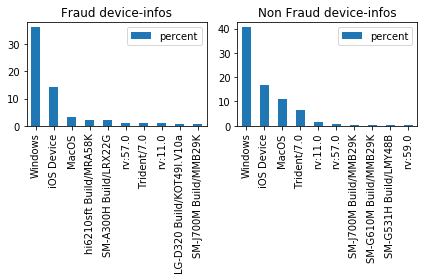

In [150]:
non_null_device_info_count_fraud = fraudulent_df.DeviceInfo.count()
non_null_device_info_count_non_fraud = non_fraudulent_df.DeviceInfo.count()

figure, axes = plt.subplots(1,2)

top_10_fraud_device_counts = fraudulent_df.DeviceInfo.value_counts().to_frame()[0:10]
top_10_fraud_device_counts = top_10_fraud_device_counts.rename(columns={"DeviceInfo": "count"})

top_10_nonfraud_device_counts = non_fraudulent_df.DeviceInfo.value_counts().to_frame()[0:10]
top_10_nonfraud_device_counts = top_10_nonfraud_device_counts.rename(columns={"DeviceInfo": "count"})

# Converting to percentages
# top10FraudDeviceInfos.count = (top10FraudDeviceInfos['count'] * 100) / non_null_device_info_count_fraud
top_10_fraud_device_counts['percent'] = top_10_fraud_device_counts['count'].apply(lambda x: (x * 100)/non_null_device_info_count_fraud)
top_10_nonfraud_device_counts['percent'] = top_10_nonfraud_device_counts['count'].apply(lambda x: (x * 100)/non_null_device_info_count_non_fraud)

top_10_fraud_device_counts.plot.bar(ax=axes[0], y='percent')
top_10_nonfraud_device_counts.plot.bar(ax=axes[1], y='percent')

axes[0].set_title("Fraud device-infos")
axes[1].set_title("Non Fraud device-infos")

plt.tight_layout()

### Analysing suspicious device infos ###

Percentage for agent: hi6210sft Build/MRA58K, fraud: 2.091, non-fraud: 0.009
Percentage for agent: SM-A300H Build/LRX22G, fraud: 1.964, non-fraud: 0.031
Percentage for agent: LG-D320 Build/KOT49I.V10a, fraud: 0.709, non-fraud: 0.009


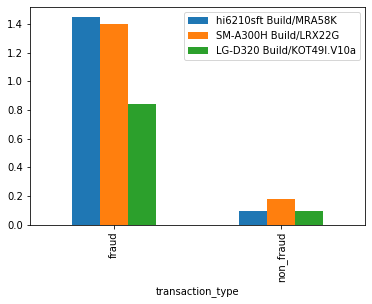

In [14]:
suspicious_device_agents = ['hi6210sft Build/MRA58K', 'SM-A300H Build/LRX22G', 'LG-D320 Build/KOT49I.V10a']
percents_in_innocent_transaction = [non_fraudulent_df[non_fraudulent_df.DeviceInfo == a].shape[0] for a in suspicious_device_agents]
percents_in_innocent_transaction = [p * 100.0 / non_null_device_info_count_non_fraud  for p in percents_in_innocent_transaction]
percents_in_innocent_transaction = [round(p, 3) for p in percents_in_innocent_transaction]

percents_in_fraud_transaction = [fraudulent_df[fraudulent_df.DeviceInfo == a].shape[0] for a in suspicious_device_agents]
percents_in_fraud_transaction = [p * 100.0 / non_null_device_info_count_fraud  for p in percents_in_fraud_transaction]
percents_in_fraud_transaction = [round(p, 3) for p in percents_in_fraud_transaction]

i = 0
df_dic = {}
df_dic['transaction_type'] = ['fraud', 'non_fraud']
for agent in suspicious_device_agents:
    df_dic[agent] = [percents_in_fraud_transaction[i], percents_in_innocent_transaction[i]]
    print("Percentage for agent: " + agent +
          ", fraud: " + str(percents_in_fraud_transaction[i]) + ", non-fraud: " + str(percents_in_innocent_transaction[i]))
    i += 1
suspicious_device_infos = pd.DataFrame(df_dic)


for agent in suspicious_device_agents:
#   Amplifying values to understand the relative scale
    suspicious_device_infos[agent] = np.sqrt(suspicious_device_infos[agent])
suspicious_device_infos.plot.bar(x='transaction_type')

### Conclusion (DeviceInfo): ###
1.  We can observe that for both fraudulent and non-fraudulent transactions, device agents: Windows/iOS/MacOS have been used most frequently
2.  But, for some special devices ('hi6210sft Build/MRA58K', 'SM-A300H Build/LRX22G', 'LG-D320 Build/KOT49I.V10a') have frequency in the range of [0.7, 2] % which may not seem significant at first glance. But it is at least 70~ times more frequent than their non fraudulent counterparts [0.009, 0.031] %
3.  A quick search on this agents reveals that these are agents of mobile devices.
4.  In summary, it seems that fraudulent transactions are done more on mobile devices

### [Part 1] Exploring DeviceType field between fraudulent vs non-fraudulent transactions ###

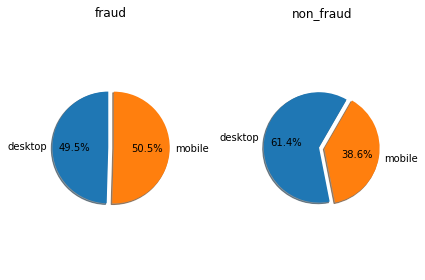

In [177]:
fraud_device_type_freq = fraudulent_df.DeviceType.value_counts().sort_values(ascending=True)
fraud_device_type_freq = fraud_device_type_freq.rename_axis('device_type').reset_index(name='freq')

non_fraud_device_type_freq = non_fraudulent_df.DeviceType.value_counts().sort_values(ascending=True)
non_fraud_device_type_freq = non_fraud_device_type_freq.rename_axis('device_type').reset_index(name='freq')

total_fraud_device_type = fraud_device_type_freq.freq.sum()
total_non_fraud_device_type = non_fraud_device_type_freq.freq.sum()

fraud_device_type_freq['percent'] = fraud_device_type_freq['freq'] * 100.0 / total_fraud_device_type
non_fraud_device_type_freq['percent'] = non_fraud_device_type_freq['freq'] * 100.0 / total_non_fraud_device_type

combined_device_type = pd.merge(fraud_device_type_freq, non_fraud_device_type_freq, on='device_type', how='outer', suffixes=['_in_fraud', '_in_non_fraud'])

# combined_device_type[['device_type', 'percent_in_fraud', 'percent_in_non_fraud']].plot.bar(x='device_type')

figures, axes = plt.subplots(1, 2)
axes[0].pie(combined_device_type['percent_in_fraud'], explode=(0.1, 0.0), labels=combined_device_type["device_type"], autopct='%1.1f%%', shadow=True, startangle=90)
axes[0].axis('equal')  
axes[0].set_title("fraud")

axes[1].pie(combined_device_type['percent_in_non_fraud'], explode=(0.0, 0.1), labels=combined_device_type["device_type"], autopct='%1.1f%%', shadow=True, startangle=60)
axes[1].axis('equal')  
axes[1].set_title("non_fraud")

plt.tight_layout()

### Conclusion (DeviceType): ###
1. Desktop devices are used less in fraudulent transactions, while mobile devices are used heavily for fraudulent transactions


### [Part 1] Exploring values of addr1 (field) for fraud vs non-fraud transactions ###

### Citation:
 https://stackoverflow.com/questions/51749208/plotting-two-histograms-from-a-pandas-dataframe-in-one-subplot-using-matplotlib

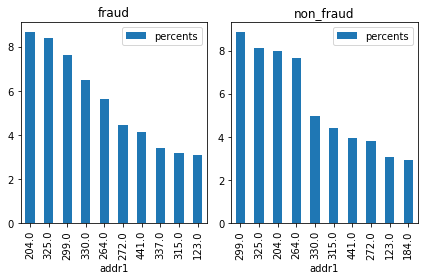

In [15]:
fraud_addr1_freq = fraudulent_df.addr1.value_counts().sort_values(ascending=False)
fraud_addr1_freq = fraud_addr1_freq.rename_axis('addr1').reset_index(name='freq')
fraud_addr1_freq['percents'] = fraud_addr1_freq['freq'] * 100.0 / fraud_addr1_freq.freq.sum()

non_fraud_addr1_freq = non_fraudulent_df.addr1.value_counts().sort_values(ascending=False)
non_fraud_addr1_freq = non_fraud_addr1_freq.rename_axis('addr1').reset_index(name='freq')
non_fraud_addr1_freq['percents'] = non_fraud_addr1_freq['freq'] * 100.0 / non_fraud_addr1_freq.freq.sum()

fraud_addr1_freq = fraud_addr1_freq[0:10]
non_fraud_addr1_freq = non_fraud_addr1_freq[0:10]

figures, axes = plt.subplots(1, 2)
fraud_addr1_freq[['addr1', 'percents']].plot.bar(x='addr1', y = ['percents'], ax=axes[0])
non_fraud_addr1_freq[['addr1', 'percents']].plot.bar(x='addr1', y = ['percents'], ax=axes[1])

axes[0].set_title('fraud')
axes[1].set_title('non_fraud')

plt.tight_layout()

### Conclusion (addr1): ###
1.  Some codes like 337 are relatively more frequent in fraudulent transactions than in non-fraudulent transactions

### [Part 1] Exploring values of addr2 (field) for fraud vs non-fraud transactions ###

C:\Users\Paras\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Paras\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


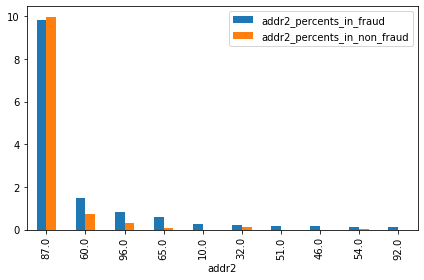

In [16]:
fraud_addr2_freq = fraudulent_df.addr2.value_counts().sort_values(ascending=False)
fraud_addr2_freq = fraud_addr2_freq.rename_axis('addr2').reset_index(name='addr2_counts')
fraud_addr2_freq['addr2_percents'] = fraud_addr2_freq['addr2_counts'] * 100.0 / fraud_addr2_freq.addr2_counts.sum()

non_fraud_addr2_freq = non_fraudulent_df.addr2.value_counts().sort_values(ascending=False)
non_fraud_addr2_freq = non_fraud_addr2_freq.rename_axis('addr2').reset_index(name='addr2_counts')
non_fraud_addr2_freq['addr2_percents'] = non_fraud_addr2_freq['addr2_counts'] * 100.0 / non_fraud_addr2_freq.addr2_counts.sum()

combined_addr2_freq = pd.merge(fraud_addr2_freq, non_fraud_addr2_freq, on='addr2', how='outer', suffixes=['_in_fraud', '_in_non_fraud'])
combined_addr2_freq = combined_addr2_freq.fillna(0)
combined_addr2_freq = combined_addr2_freq[0:10]

addr2_freq_scaled = combined_addr2_freq[['addr2', 'addr2_percents_in_fraud', 'addr2_percents_in_non_fraud']]
addr2_freq_scaled['addr2_percents_in_fraud'] = np.sqrt(addr2_freq_scaled['addr2_percents_in_fraud'])
addr2_freq_scaled['addr2_percents_in_non_fraud'] = np.sqrt(addr2_freq_scaled['addr2_percents_in_non_fraud'])
addr2_freq_scaled.plot.bar(x='addr2', y=['addr2_percents_in_fraud', 'addr2_percents_in_non_fraud'])
plt.tight_layout()

In [17]:
combined_addr2_freq['percent_ratio'] = combined_addr2_freq['addr2_percents_in_fraud'] / combined_addr2_freq['addr2_percents_in_non_fraud']

In [18]:
combined_addr2_freq.head(10)

,addr2,addr2_counts_in_fraud,addr2_percents_in_fraud,addr2_counts_in_non_fraud,addr2_percents_in_non_fraud,percent_ratio
0,87.0,12477.0,96.556261,508004.0,99.236588,0.972991
1,60.0,279.0,2.159108,2805.0,0.547946,3.940369
2,96.0,89.0,0.688748,549.0,0.107245,6.422191
3,65.0,44.0,0.340505,38.0,0.007423,45.870625
4,10.0,8.0,0.061910,0.0,0.000000,inf
5,32.0,6.0,0.046432,85.0,0.016604,2.796391
6,51.0,4.0,0.030955,0.0,0.000000,inf
7,46.0,3.0,0.023216,0.0,0.000000,inf
8,54.0,2.0,0.015477,4.0,0.000781,19.807770
9,92.0,2.0,0.015477,0.0,0.000000,inf


### Conclusion (addr2): ###
1.  Countries with country code: 60, 96, 65, 10, indicate significant transactions in fraud data-set relative to non-fraud data-set
2.  Distribution percentage of above codes [2.1, 0.6, 0.3, 0.06] % in fraud whereas in non-fraud it is [0.5, 0.1, 0, 0]
3.  Though the range of percentage is too small to make major conclusions.
4.  Yet, the corresponding ratio is in order of 3 times, 4 times, 45 times, indefinite times
5.  Example for country code 10.0, all the transactions were fraud and none of the transactions made from country-code 10.0 are non-fraud

### [Part 1] Exploring P_emaildomain (purchaser email) between fraud and non-fraud transactions

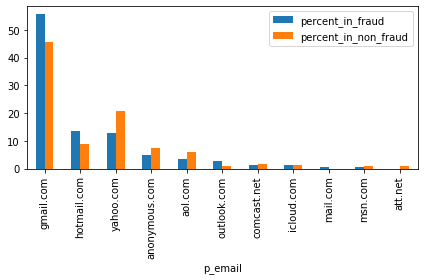

In [19]:
fraud_p_email_freq =  fraudulent_df.P_emaildomain.value_counts().sort_values(ascending=False)
fraud_p_email_freq = fraud_p_email_freq.rename_axis('p_email').reset_index(name='freq')
fraud_p_email_freq['percent'] = fraud_p_email_freq['freq'] * 100.0 / fraud_p_email_freq.freq.sum()
fraud_p_email_freq = fraud_p_email_freq[0:10]

non_fraud_p_email_freq = non_fraudulent_df.P_emaildomain.value_counts().sort_values(ascending=False)
non_fraud_p_email_freq = non_fraud_p_email_freq.rename_axis('p_email').reset_index(name='freq')
non_fraud_p_email_freq['percent'] = non_fraud_p_email_freq['freq'] * 100.0 / non_fraud_p_email_freq.freq.sum()
non_fraud_p_email_freq = non_fraud_p_email_freq[0:10]

combined_p_email_freq = pd.merge(fraud_p_email_freq, non_fraud_p_email_freq, how='outer', on='p_email', suffixes=["_in_fraud", "_in_non_fraud"])
combined_p_email_freq = combined_p_email_freq.fillna(0.0)

combined_p_email_freq[['p_email', 'percent_in_fraud', 'percent_in_non_fraud']].plot.bar(x='p_email')
plt.tight_layout()


### Conclusion (P_emaildomain):
1.  Almost all the email domains used in non-fraud transactions are popular in fraud transactinos
2.  The only difference is yahoo.com, anonymous.com aol.com which are used less frequent in fraud transactions
3.  The other key difference is mail.com is explicitly used in fraud transactions

### [Part 1] Exploring R_emaildomain (receipient) between fraud and non-fraud transactions

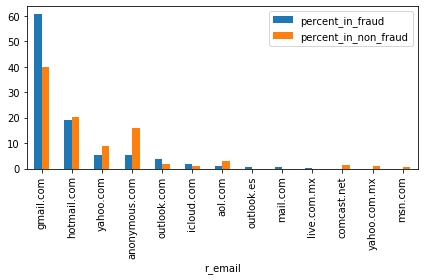

In [21]:
fraud_r_email_freq =  fraudulent_df.R_emaildomain.value_counts().sort_values(ascending=False)
fraud_r_email_freq = fraud_r_email_freq.rename_axis('r_email').reset_index(name='freq')
fraud_r_email_freq['percent'] = fraud_r_email_freq['freq'] * 100.0 / fraud_r_email_freq.freq.sum()
fraud_r_email_freq = fraud_r_email_freq[0:10]

non_fraud_r_email_freq = non_fraudulent_df.R_emaildomain.value_counts().sort_values(ascending=False)
non_fraud_r_email_freq = non_fraud_r_email_freq.rename_axis('r_email').reset_index(name='freq')
non_fraud_r_email_freq['percent'] = non_fraud_r_email_freq['freq'] * 100.0 / non_fraud_r_email_freq.freq.sum()
non_fraud_r_email_freq = non_fraud_r_email_freq[0:10]

combined_r_email_freq = pd.merge(fraud_r_email_freq, non_fraud_r_email_freq, how='outer', on='r_email', suffixes=["_in_fraud", "_in_non_fraud"])
combined_r_email_freq = combined_r_email_freq.fillna(0.0)

combined_r_email_freq[['r_email', 'percent_in_fraud', 'percent_in_non_fraud']].plot.bar(x='r_email')
plt.tight_layout()


### Conclusion (R_emaildomain):
1.  gmail.com is proportionally more frequent in fraud transactions than non-fraud transactions
2.  outlook.es, mail.com, live.com.mx are explicitly used in fraud transactions

### [Part-1] Exploring dist1 and dist2 distributions between fraud and non-fraud transactions

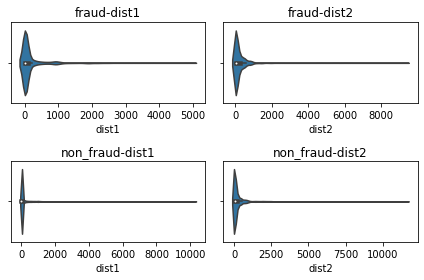

In [202]:
figures, axes = plt.subplots(2,2)
sns.violinplot(x=fraudulent_df["dist1"], ax=axes[0,0])
sns.violinplot(x=fraudulent_df["dist2"], ax=axes[0,1])
sns.violinplot(x=non_fraudulent_df["dist1"], ax=axes[1,0])
sns.violinplot(x=non_fraudulent_df["dist2"], ax=axes[1,1])
axes[0,0].set_title("fraud-dist1")
axes[0,1].set_title("fraud-dist2")
axes[1,0].set_title("non_fraud-dist1")
axes[1,1].set_title("non_fraud-dist2")

plt.tight_layout()

### Conclusion (dist1/dist2):
1. Dist1 and Dist2 is centered around median more in fraudulent transaction than non-fraudulent transaction
2. There is high variance for distances in non-fraudulent transaction

### [Part-1] Exploring Transaction amount between fraud and non-fraud transactions

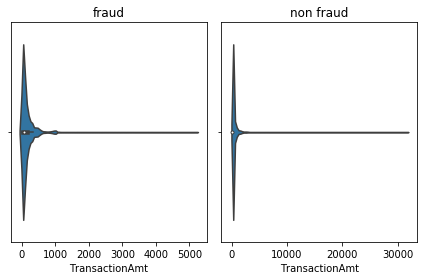

In [209]:
figures, axes = plt.subplots(1,2)
sns.violinplot(x=fraudulent_df["TransactionAmt"], ax=axes[0])
sns.violinplot(x=non_fraudulent_df["TransactionAmt"], ax=axes[1])
axes[0].set_title("fraud")
axes[1].set_title("non fraud")

plt.tight_layout()

### Conclusion:
1. A high variance of transaction amount is observed in fraud transactions than non-fraud transactions
2. The transaction amount are scaled to lower range of amount for fraud than non fraud transactions

### [Part 1] Observing distributions of fields among fraudulent and non-fraudulent transactions ###

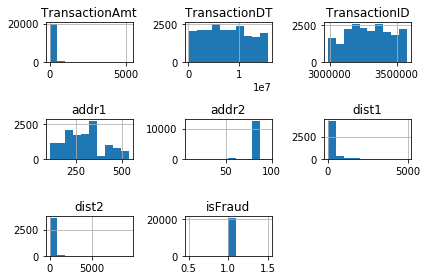

In [210]:
fraud_hists = fraudulent_df.hist()
plt.tight_layout()

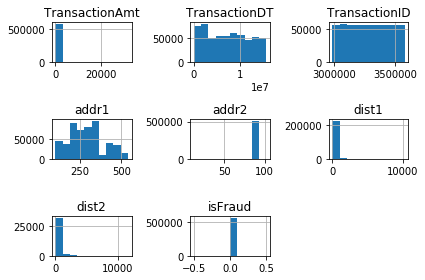

In [211]:
non_fraud_hists = non_fraudulent_df.hist()
plt.tight_layout()

## Conclusion ##
Apart from maximum frequency all histograms depict same kind of spread of values between fraudulent transactions and non-fraudulent transactions. The maximum frequency is different obviously because fraudulent transactions are only small fraction (~ 4%) of the global data-set

## Observing max-min-std of the fields among fraud vs non-fraud transactions ##

In [212]:
fraudulent_df.describe()

,TransactionID,TransactionDT,TransactionAmt,addr1,addr2,dist1,dist2,isFraud
count,2.066300e+04,2.066300e+04,20663.000000,12922.000000,12922.000000,4755.000000,3731.000000,20663.0
mean,3.294952e+06,7.690033e+06,149.244779,294.317134,86.286024,174.588854,201.472259,1.0
std,1.620403e+05,4.416551e+06,232.212163,103.584955,4.936238,424.232313,451.589576,0.0
min,2.987203e+06,8.976000e+04,0.292000,110.000000,10.000000,0.000000,0.000000,1.0
25%,3.167366e+06,3.965858e+06,35.044000,204.000000,87.000000,3.000000,7.000000,1.0
50%,3.291934e+06,7.575230e+06,75.000000,299.000000,87.000000,10.000000,49.000000,1.0
75%,3.428646e+06,1.121743e+07,161.000000,330.000000,87.000000,85.500000,233.000000,1.0
max,3.577526e+06,1.581088e+07,5191.000000,536.000000,96.000000,4942.000000,9337.000000,1.0


In [213]:
non_fraudulent_df.describe()

,TransactionID,TransactionDT,TransactionAmt,addr1,addr2,dist1,dist2,isFraud
count,5.698770e+05,5.698770e+05,569877.000000,511912.000000,511912.000000,233514.000000,33896.000000,569877.0
mean,3.281810e+06,7.360791e+06,134.511665,290.643341,86.813620,117.360098,235.199758,0.0
std,1.707548e+05,4.623930e+06,239.395078,101.692564,2.607742,370.641879,536.798492,0.0
min,2.987000e+06,8.640000e+04,0.251000,100.000000,13.000000,0.000000,0.000000,0.0
25%,3.133317e+06,3.010651e+06,43.970000,204.000000,87.000000,3.000000,7.000000,0.0
50%,3.281808e+06,7.271678e+06,68.500000,299.000000,87.000000,8.000000,36.000000,0.0
75%,3.429974e+06,1.125334e+07,120.000000,330.000000,87.000000,24.000000,206.000000,0.0
max,3.577539e+06,1.581113e+07,31937.391000,540.000000,102.000000,10286.000000,11623.000000,0.0


## Conclusion ##


1.   The max value of `TransactionAmt` for fraudulent transactions is 5191, whereas for non-fraudulent transaction it is 31937 (which is roughly 6 times). This suggests that fraudulent transactions are possibly done in smaller denominations may be to avoid flagging or alerting existing Fraud-Detection Systems 
2.   The max value of `dist1` for fraudulent transactions is 4942, whereas for non-fraudulent transaction it is 10286 (which is roughly twice). It suggests that either the fraudster did frauds at smaller distances or  fraudster recorded fake details regarding address or distances in their order details of locations they are aware of (possibly closer to their residences)
3.   The standard deviation of `addr2` of fraudulent transactions is 4.93, whereas for non-fraudulent transactions is 2.6 (which is roughly half). This indicates that the spread of billing region or billing country details for fraudulent transactions is much higher may be because the fraudster were faking their details



## Part 2 - Transaction Frequency

### Citation:
1. https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
2. https://stackoverflow.com/questions/21441259/pandas-groupby-range-of-values

In [214]:
country_code_freq = basic_fields_df['addr2'].value_counts()
country_code_freq = country_code_freq.rename_axis('country_code').reset_index(name='country_transaction_counts')
country_code_freq.head()

,country_code,country_transaction_counts
0,87.0,520481
1,60.0,3084
2,96.0,638
3,32.0,91
4,65.0,82


### [Part-2] Maximum transaction country ###
We can see in the above step that the country with maximum transactions is the country having country-code, 87 (~ 88% of transactions).
So in the next step we observe the values of country with code 87. 

### [Part-2] We will calculate different time-level tags based on different time widths (86400, 3600, 60) and modulo operator
1. First we will calculate day-level-tags (ith day in the time frame of whole data-set)
2. Then we will calculate hour-level-tags (ith hour in the time frame of whole data-set)
3. Then we will calculate minute-level-tags(ith minute in the time frame of whole day)
4. In the end we will analyse time tag wise distribution for countries with code 87

In [215]:
max_transaction_dt = 16000000 # max value in data-set
transaction_bin_width = 86400  # no. of seconds in a day
possible_bins = np.arange(0, max_transaction_dt + transaction_bin_width, transaction_bin_width)
row_bin_tags = pd.cut(basic_fields_df["TransactionDT"], bins=possible_bins, labels=np.arange(len(possible_bins) - 1))
basic_fields_df['day_tags'] = row_bin_tags

transaction_bin_width = 3600 # no. of seconds in an hour
possible_bins = np.arange(0, max_transaction_dt + transaction_bin_width, transaction_bin_width)
row_bin_tags = pd.cut(basic_fields_df["TransactionDT"], bins=possible_bins, labels=np.arange(len(possible_bins) - 1))
basic_fields_df['hour_tags'] = row_bin_tags

transaction_bin_width = 60 # no. of seconds in an minute
possible_bins = np.arange(0, max_transaction_dt + transaction_bin_width, transaction_bin_width)
row_bin_tags = pd.cut(basic_fields_df["TransactionDT"], bins=possible_bins, labels=np.arange(len(possible_bins) - 1))
basic_fields_df['minute_tags'] = row_bin_tags

# Converting categorical columns to int
categorical_columns = ['day_tags', 'hour_tags', 'minute_tags']
basic_fields_df[categorical_columns] = basic_fields_df[categorical_columns].apply(lambda x: x.cat.codes)
basic_fields_df['day_tags'] = basic_fields_df['day_tags'].astype(np.int64)
basic_fields_df['hour_tags'] = basic_fields_df['hour_tags'].astype(np.int64)
basic_fields_df['minute_tags'] = basic_fields_df['minute_tags'].astype(np.int64)

# Calculating hour of the day (0 to 23) based on hour_tags
basic_fields_df['hour_of_day'] = basic_fields_df['hour_tags'] % 24
basic_fields_df['minute_of_day'] = basic_fields_df['minute_tags'] % 1440

C:\Users\Paras\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Paras\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Paras\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:

In [216]:
most_frequent_country = basic_fields_df[basic_fields_df.addr2 == 87]

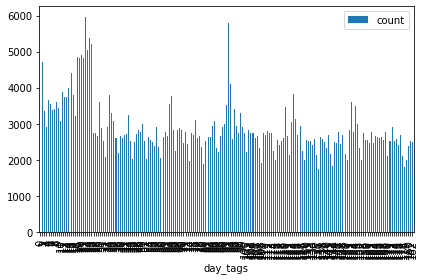

In [217]:
dayWiseTransactionCount = most_frequent_country.groupby("day_tags")["TransactionID"].agg(['count'])
dayWiseTransactionCount.plot.bar()
plt.tight_layout()

## Conclusion ##
Majority of the transactions were done in the earlier days in the time frame.

There are only few outliers (2-3 days) in the six month time frame, this may suggest that during the initial time-frame of days there was some sale or other external factor influencing large number of transactions

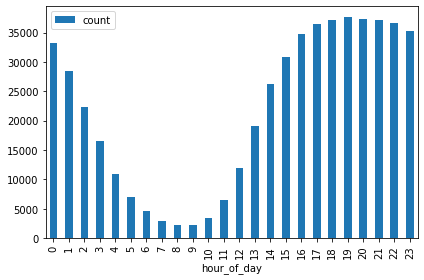

In [38]:
hourWiseTransactionCount = most_frequent_country.groupby("hour_of_day")["TransactionID"].agg(['count'])
hourWiseTransactionCount.plot.bar()
plt.tight_layout()

## Conclusion ##
1. As we can see in the above plot, that a majority of transactions are calculated in hours (hour 0 to hour 2) and in late hours (hour 15 to hour 23).
2. This indicates majority of the people who reside in country with code 87, have their waking hours as per base reference, from hour 0 to hour 4 and hour 13 to hour 23. 
3. So waking hours of people in country code 87, lies in ranges [13, 23], [0, 4]

## Part 3 - Product Code

In [238]:
# TODO: code to analyze prices for different product codes
values = basic_fields_df.ProductCD.value_counts()
values = values.rename_axis('product').reset_index(name='freq')
values.head()

,product,freq
0,W,439670
1,C,68519
2,R,37699
3,H,33024
4,S,11628


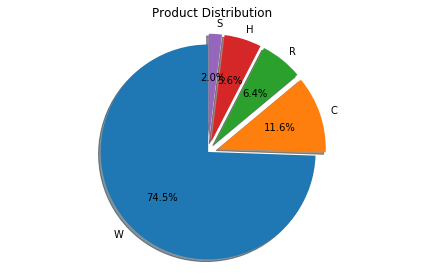

In [239]:
figures, axes = plt.subplots()
axes.pie(values["freq"], explode=(0, 0.1, 0.1, 0.1, 0.1), labels=values["product"], autopct='%1.1f%%', shadow=True, startangle=90)
axes.axis('equal')  
axes.set_title("Product Distribution")

plt.tight_layout()

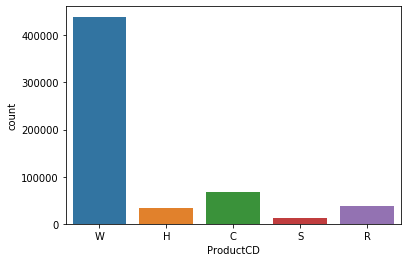

In [240]:
sns.countplot(x='ProductCD', data=basic_fields_df)

In [241]:
product_agg_df = basic_fields_df.groupby(["ProductCD"])["TransactionID", "TransactionAmt"].agg(["min", "max", "count"])
product_agg_df.columns = ["_".join(x) for x in product_agg_df.columns.ravel()] # normalizing hierarchical column names
product_agg_df

,TransactionID_min,TransactionID_max,TransactionID_count,TransactionAmt_min,TransactionAmt_max,TransactionAmt_count
ProductCD,,,,,,
C,2987010,3577534,68519,0.251,712.896,68519
H,2987004,3577506,33024,15.000,500.000,33024
R,2987099,3577531,37699,25.000,1800.000,37699
S,2987038,3577184,11628,5.000,1550.000,11628
W,2987000,3577539,439670,1.000,31937.391,439670


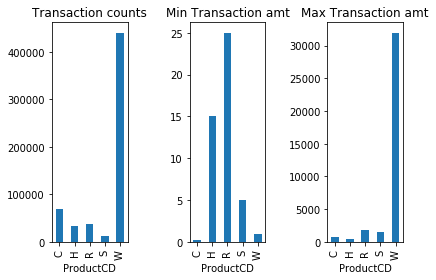

In [242]:
figure, axes = plt.subplots(1,3)

product_agg_df["TransactionID_count"].plot.bar(ax=axes[0])
product_agg_df["TransactionAmt_min"].plot.bar(ax=axes[1])
product_agg_df["TransactionAmt_max"].plot.bar(ax=axes[2])


axes[0].set_title("Transaction counts")
# axes[0].title.set_size(10)
axes[1].set_title("Min Transaction amt")
# axes[1].title.set_size(10)
axes[2].set_title("Max Transaction amt")
# axes[2].title.set_size(10)
# axes[1].set_title("non_fraud")
# plt.subplot(1,0, 0)

plt.tight_layout()

## Conclusion ##

1.   Product R is the product which has relatively highest minimum transaction amount among its peers. It also has moderate to least amount of purchases. This indicates that is a product which is bought least amount of times as well as whenever it was bought in a minimum amount transaction it would cost more than its peers
2.   Product R is most expensive product
3.   Product C has more balance stats. Its' transaction counts are second highest (indicating it is a product that people buy most). As well as the minimum transaction amount of Product C is lowest.
3.   Product C is cheapest

Write your answer here

## Part 4 - Correlation Coefficient

Since, the TransactionAmt is a highly skewed signal, we will use natural logarithm of the field to understand it's nature with other signals 

In [243]:
basic_fields_df["TransactionAmtLog"] = np.log(basic_fields_df["TransactionAmt"])
basic_fields_df["hour_of_day_log"] = np.log(basic_fields_df["hour_of_day"])
basic_fields_df["minute_of_day_log"] = np.log(basic_fields_df["minute_of_day"])

C:\Users\Paras\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Paras\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
C:\Users\Paras\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Paras\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ip

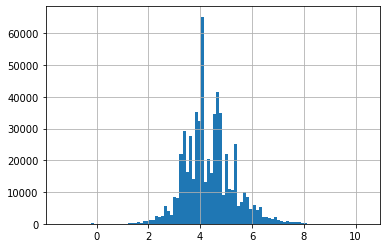

In [244]:
basic_fields_df["TransactionAmtLog"].hist(bins=100)

### Citation ###
https://stats.stackexchange.com/questions/127121/do-logs-modify-the-correlation-between-two-variables

In [245]:
# TODO: code to calculate correlation coefficient
amountVsTime = basic_fields_df[["hour_of_day", "hour_of_day_log", "minute_of_day", "minute_of_day_log", "TransactionAmt", "TransactionAmtLog"]].corr()
amountVsTime

,hour_of_day,hour_of_day_log,minute_of_day,minute_of_day_log,TransactionAmt,TransactionAmtLog
hour_of_day,1.000000,0.947394,0.999287,0.900773,0.044526,0.062019
hour_of_day_log,0.947394,1.000000,0.946858,0.996571,0.047206,0.067163
minute_of_day,0.999287,0.946858,1.000000,0.902921,0.044565,0.062038
minute_of_day_log,0.900773,0.996571,0.902921,1.000000,0.039788,0.056623
TransactionAmt,0.044526,0.047206,0.044565,0.039788,1.000000,0.701519
TransactionAmtLog,0.062019,0.067163,0.062038,0.056623,0.701519,1.000000


In [246]:
basic_fields_df[["hour_of_day", "hour_of_day_log", "minute_of_day", "minute_of_day_log", "TransactionAmt", "TransactionAmtLog"]].corr(method='spearman')

,hour_of_day,hour_of_day_log,minute_of_day,minute_of_day_log,TransactionAmt,TransactionAmtLog
hour_of_day,1.000000,1.000000,0.998190,0.998191,0.038325,0.038325
hour_of_day_log,1.000000,1.000000,0.997953,0.997953,0.034320,0.034320
minute_of_day,0.998190,0.997953,1.000000,1.000000,0.038098,0.038098
minute_of_day_log,0.998191,0.997953,1.000000,1.000000,0.038111,0.038111
TransactionAmt,0.038325,0.034320,0.038098,0.038111,1.000000,1.000000
TransactionAmtLog,0.038325,0.034320,0.038098,0.038111,1.000000,1.000000


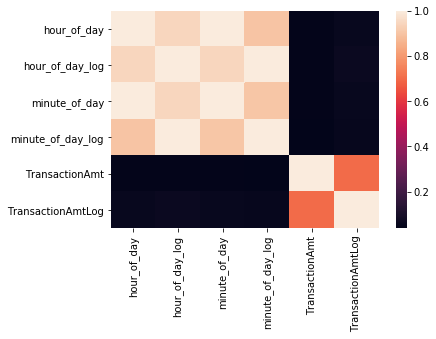

In [247]:
sns.heatmap(amountVsTime)

#### Since, we do not observe any direct significant correlation between time features and TransactionAmt, we will observe correlation between aggregations of TransactionAmt and time feature

In [248]:
hour_of_day_agg = basic_fields_df[["TransactionAmt", "hour_of_day"]].groupby(["hour_of_day"]).agg(["min", "max", "sum", "mean"])
hour_of_day_agg.columns = ["_".join(x) for x in hour_of_day_agg.columns.ravel()]
hour_of_day_agg = hour_of_day_agg.reset_index()

In [249]:
hour_of_day_agg.corr()

,hour_of_day,TransactionAmt_min,TransactionAmt_max,TransactionAmt_sum,TransactionAmt_mean
hour_of_day,1.000000,-0.272370,0.442888,0.642113,0.750549
TransactionAmt_min,-0.272370,1.000000,-0.211226,-0.644655,-0.001912
TransactionAmt_max,0.442888,-0.211226,1.000000,0.335614,0.123193
TransactionAmt_sum,0.642113,-0.644655,0.335614,1.000000,0.618035
TransactionAmt_mean,0.750549,-0.001912,0.123193,0.618035,1.000000


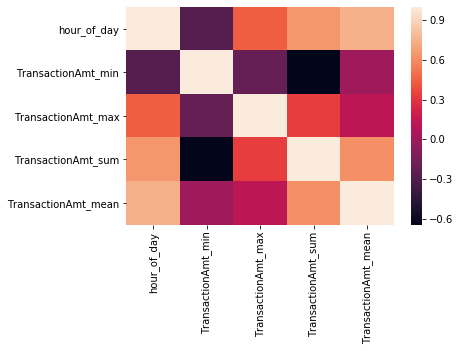

In [250]:
sns.heatmap(hour_of_day_agg.corr())

### Conclusion
#### 1. Moderate correlation between sum of the TransactionAmt in an hour and hour of day is observed 
#### (Correlation value = 0.642)
#### 2. High correlation between mean TransactionAmt for an hour and hour of day is observed
#### (Correlation value = 0.75)

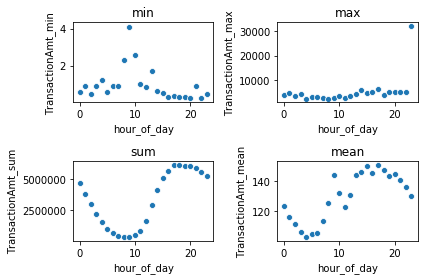

In [251]:
figures, axes = plt.subplots(2,2)
sns.scatterplot(x="hour_of_day", y="TransactionAmt_min", data=hour_of_day_agg, ax=axes[0,0])
sns.scatterplot(x="hour_of_day", y="TransactionAmt_max", data=hour_of_day_agg, ax=axes[0,1])
sns.scatterplot(x="hour_of_day", y="TransactionAmt_sum", data=hour_of_day_agg, ax=axes[1,0])
sns.scatterplot(x="hour_of_day", y="TransactionAmt_mean", data=hour_of_day_agg, ax=axes[1,1])

axes[0,0].set_title("min")
axes[0,1].set_title("max")
axes[1,0].set_title("sum")
axes[1,1].set_title("mean")

plt.tight_layout()

## Part 5 - Interesting Plot

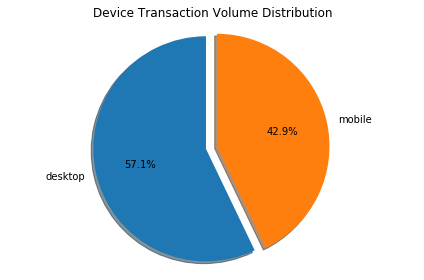

In [288]:
device_type_agg = basic_fields_df.groupby(["DeviceType"])["TransactionAmt"].agg(["mean"])
device_type_agg = device_type_agg.reset_index()

figures, axes = plt.subplots()
axes.pie(device_type_agg["mean"], explode=(0, 0.1), labels=device_type_agg["DeviceType"], autopct='%1.1f%%', shadow=True, startangle=90)
axes.axis('equal')  
axes.set_title("Device Transaction Volume Distribution")

plt.tight_layout()

### [Part-5] Conclusion (Insight):
People when doing transactions containing large amount on average would prefer to do more on desktop devices than on mobile devices

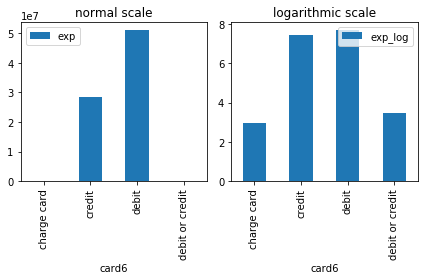

In [100]:
expenses = basic_fields_df.groupby(['card6'])['TransactionAmt'].agg(['sum'])
expenses = expenses.rename(columns={"sum": "exp"})

expenses['exp_log'] = np.log10(expenses['exp'])

figure, axes = plt.subplots(1,2)
expenses.plot.bar(ax=axes[0], y='exp')
expenses.plot.bar(ax=axes[1], y='exp_log')

axes[0].set_title("normal scale")
axes[1].set_title("logarithmic scale")
plt.tight_layout()

In [280]:
instances_where_dist1_dist2_exist = basic_fields_df[(basic_fields_df.dist1.notnull() & basic_fields_df.dist2.notnull())].shape[0]
instances_where_dist1_dist2_exist

0

### [Part-5] Conclusion (Insight) 
1.  As you can notice that, most expenses are done through debit card followed by credit card. The least expenses are done through charge card
#### 2.  This indicates that people prefer to stay under their credit limit, else they will have to pay penalty interest rates.  Possibly fear of penalty drive people to use less or avoid using credit card for major expenses. This reveals risk-averse nature of people to some extent
3.  Also, the minimal expenses on charge card compared to credit card indicate that people are ready to face interest rates of credit card for late payment but are not ready to face heavy late penalty fees on charge card. A simple search on the internet highlights that late penalty fees on charge card are in more costly than on interest on credit card
4.  There are no instances in data-set where both dist1 and dist2 are measured and available

### [Part-5] Conclusion (EDA):
1.  The above EDA helped me to spot missing data and the potential lack of signal to build a good predictor
2.  It taught me how to organize, structure and munge data
3.  It also helped me to test certain hypothesis or invalidate my assumptions

Write your answer here

## Part 6 - Prediction Model

In [173]:
# TODO: code for your final model

## Checking First for duplicates for the significant fields across whole data-set
Testing whether there are any duplicates in the base data (TransactionID, DeviceType, DeviceInfo, TransactionDT, TransactionAmt, ProductCD, addr1, addr2, dist1, dist2, card4, card6, P_emaildomain, R_emaildomain) of transactions and devices.

---

Found that there are no duplicates since shape on `base_df[base_duplicates]` responds with 0 count against number of rows


In [102]:
base_duplicates = basic_fields_df.duplicated()
print("Number of duplicates in base fields: " + str(basic_fields_df[base_duplicates].shape[0]))

Number of duplicates in base fields: 0


### Loading train and test data in dataframes

In [103]:
train_identity_df = pd.read_csv("../data/train_identity.csv")
train_transaction_df = pd.read_csv("../data/train_transaction.csv")
test_identify_df = pd.read_csv('../data/test_identity.csv')
test_transaction_df = pd.read_csv('../data/test_transaction.csv')

### Missing values in card6(credit/debit)
Since card6 and card4 field null counts are not high, filling it with place-holders of credit/debit with equal probability

In [104]:
def handle_missing_values_in_card6(input_df, is_test_data):
    print("==================== Solving missing values for card6 ====================")
    modified_df = input_df.copy(deep=True)
    nan_indices = modified_df.index[modified_df.card6.isnull()]
    test_card6_replacements = random.choices(['credit', 'debit'], [1, 1], k=nan_indices.shape[0])
    i = 0
    for index in nan_indices:
        modified_df.iloc[index, modified_df.columns.get_loc('card6')] = test_card6_replacements[i]
        if i % 100 == 0:
            print("card6 filling, done with " + str(i) + " , remaining: " + str(len(nan_indices) - i))
        i += 1
    
    print("==================== Resolved card6 ====================")
    
    return modified_df

### Missing values in card4(card issuer: visa, mastercard)
Since card6 and card4 field null counts are not high, filling it with place-holders of credit/debit with equal probability

In [105]:
def handle_missing_values_in_card4(input_df, test_data):
    print("==================== Solving missing values for card4 ====================")
    
    modified_df = input_df.copy(deep=True)
    nan_indices = modified_df.index[modified_df.card4.isnull()]
    test_card4_replacements = random.choices(['visa', 'mastercard', 'american express', 'discover'], [1, 1, 1, 1], k=nan_indices.shape[0])
    i = 0
    for index in nan_indices:
        modified_df.iloc[index, modified_df.columns.get_loc('card4')] = test_card4_replacements[i]
        if i % 100 == 0:
            print("Test data card4 filling, done with " + str(i) + " , remaining: " + str(len(nan_indices) - i))
        i += 1
    
    print("==================== Resolved 
    return modified_df

### Missing values for address fields imputed with defaults

In [174]:
def handle_missing_values_in_addr(input_df):
    print("==================== Solving missing values for addr1/addr2 ====================")
    
    modified_df = input_df.copy(deep=True)
    
    modified_df['addr1'] = modified_df['addr1'].fillna('special_region')
    modified_df['addr2'] = modified_df['addr2'].fillna('special_country')
    
    print("==================== Resolved addr1/addr2 ====================")
    
    return modified_df

### Mapping multiple same domain to common root domain
1. Multiple same emails belonging to same domain like 'gmail.com' and 'gmail' are incorrectly present in training-dataset, due to some measurement error
2. Imputing missing values of purchaser and receipient email

In [175]:
def handle_emails(input_df):
    modified_df = input_df.copy(deep=True)
    
    email_domain_map = {
	'gmail.com': ['gmail.com', 'gmail'], 
  	'yahoo.com': ['yahoo.com', 'yahoo.com.mx', 'ymail.com', 'yahoo.de', 'yahoo.fr', 'yahoo.es', 'yahoo.co.uk', 'yahoo.co.jp'] , 
  	'hotmail.com': ['hotmail.com', 'outlook.com', 'live.com.mx', 'hotmail.es', 'msn.com', 'live.com', 'outlook.es', 'hotmail.de', 'hotmail.fr', 'hotmail.co.uk'],
  	'netzero.net': ['netzero.com', 'netzero.net'] ,
  	'icloud.com': ['mac.com', 'icloud.com']
    }

    reverse_email_domain_map = {}
    for root_domain in email_domain_map:
        for domain in email_domain_map[root_domain]:
            reverse_email_domain_map[domain] = root_domain
    # reverse_email_domain_map

    modified_df['P_emaildomain'] = modified_df['P_emaildomain'].fillna('special_purchaser_email')
    modified_df['R_emaildomain'] = modified_df['R_emaildomain'].fillna('special_receipient_email')
  
    modified_df['P_emaildomain'] = modified_df['P_emaildomain'].apply(lambda x: reverse_email_domain_map[x] if x in reverse_email_domain_map else x)
    modified_df['R_emaildomain'] = modified_df['R_emaildomain'].apply(lambda x: reverse_email_domain_map[x] if x in reverse_email_domain_map else x)
    
    return modified_df

### Utility to drop columns from data-frame

In [176]:
def drop_columns(input_df, column_names):
    print("==================== Dropping some columns ====================")
    return input_df.drop(column_names, axis = 1) # non-inplace drop, the input_df will still have its all columns

### Utility to encode categorical variables

In [109]:
def one_hot_encode(df, col_name, col_prefix=''):
    print("==================== Encoding "+ col_name + " ====================")
    
    if len(col_prefix) > 0:
        one_hot_encoding = pd.get_dummies(df[col_name], prefix=col_prefix)
    else:
        one_hot_encoding = pd.get_dummies(df[col_name])
    new_df = df.copy(deep=True)
    new_df = new_df.drop(col_name, axis=1)
    new_df = new_df.join(one_hot_encoding)
    
    return new_df

In [121]:
def encode_categorical_fields(input_df):
    print("==================== Encoding categorical columns ====================")
    pre_processing_df = input_df.copy(deep=True)
    
    pre_processing_df = one_hot_encode(pre_processing_df, 'card4')
    pre_processing_df = one_hot_encode(pre_processing_df, 'card6')
    pre_processing_df = one_hot_encode(pre_processing_df, 'ProductCD')
    pre_processing_df = one_hot_encode(pre_processing_df, 'DeviceType')
    pre_processing_df = one_hot_encode(pre_processing_df, 'addr1', col_prefix='addr1_')
    pre_processing_df = one_hot_encode(pre_processing_df, 'addr2', col_prefix='addr2_')
    pre_processing_df = one_hot_encode(pre_processing_df, 'P_emaildomain', col_prefix='P_emaildomain_')
    pre_processing_df = one_hot_encode(pre_processing_df, 'R_emaildomain', col_prefix='R_emaildomain_')
    
    print("==================== Done encoding categorical fields ====================")

    return pre_processing_df

### Pre-processing training data-set
### Steps:
1. Left join identity and transaction data TransactionID (Since not all TransactionID are present in identity dataset)
2. Keep the necessary fields for training
3. Handle missing values for: card5, card4, addr1, addr2
4. Map multiple email domains to root email domain
5. Handle missing values for: P_emaildomain, R_emaildomain
6. One-Hot-Encode categorical fields: card4, card6, ProductCD, DeviceType, addr1, addr2, P_emaildomain, R_emaildomain

### Currently not addressing missing values in DeviceInfo and distance fields

In [110]:
def pre_process_df(identity_df, transaction_df):
    print("==================== Pre-Processing begins! ====================")
    
    global_df = pd.merge(left=transaction_df, right=identity_df, left_on=["TransactionID"],
                                       right_on="TransactionID", how="left")
    basic_fields_df = global_df[["TransactionID", "TransactionDT", "TransactionAmt",
                                              "ProductCD", "card4", "card6", "P_emaildomain", "R_emaildomain", 
                                              "addr1", "addr2", "dist1", "dist2", "isFraud", "DeviceType", "DeviceInfo"]]
    modified_df = basic_fields_df.copy(deep=True)
    print("Pre-Processing initial shape: " + str(modified_df.shape))
    
    modified_df = handle_missing_values_in_card6(modified_df, False)
    modified_df = handle_missing_values_in_card4(modified_df, False)
    modified_df = handle_missing_values_in_addr(modified_df)
    modified_df = handle_emails(modified_df)
    
    pre_processing_df = drop_columns(modified_df, ['TransactionID', 'dist1', 'dist2', 'DeviceInfo'])
    pre_processing_df = encode_categorical_fields(pre_processing_df)
    
    print("Pre-Processing final shape: " + str(pre_processing_df.shape))
    print("==================== Done Pre-Processing ====================")
    
    
    return pre_processing_df
    

In [111]:
def add_missing_dummy_columns(test_df, train_columns ):
    missing_cols = set(train_columns) - set(test_df.columns)
    for c in missing_cols:
        test_df[c] = 0

### Citation: To handle categorical values in test data-set
1. http://fastml.com/how-to-use-pd-dot-get-dummies-with-the-test-set/
2. https://stackoverflow.com/questions/41335718/keep-same-dummy-variable-in-training-and-testing-data

In [114]:
def fix_columns(test_df, train_df):  

    add_missing_dummy_columns(test_df, train_df.columns)

    # make sure we have all the columns we need
    assert(set(train_df.columns) - set( test_df.columns ) == set())

    extra_cols = set(test_df.columns) - set(train_df.columns)
    if extra_cols:
        print("extra columns:", extra_cols)

    test_df = test_df[train_df.columns]
    return test_df

In [115]:
def pre_process_test_df(identity_df, transaction_df, train_df):
    print("==================== Pre-Processing begins! ====================")
    
    global_df = pd.merge(left=transaction_df, right=identity_df, left_on=["TransactionID"],
                                       right_on="TransactionID", how="left")
    basic_fields_df = global_df[["TransactionID", "TransactionDT", "TransactionAmt",
                                                  "ProductCD", "card4", "card6", "P_emaildomain", "R_emaildomain", 
                                                  "addr1", "addr2", "dist1", "dist2", "DeviceType", "DeviceInfo"]]

    modified_df = basic_fields_df.copy(deep=True)
    print("Pre-Processing initial shape: " + str(modified_df.shape))
    
    modified_df = handle_missing_values_in_card6(modified_df, True)
    modified_df = handle_missing_values_in_card4(modified_df, True)
    modified_df = handle_missing_values_in_addr(modified_df)
    modified_df = handle_emails(modified_df)
    
    pre_processing_df = drop_columns(modified_df, ['TransactionID', 'dist1', 'dist2', 'DeviceInfo'])
    pre_processing_df = encode_categorical_fields(pre_processing_df)
    pre_processing_df = fix_columns(pre_processing_df, train_df)
    
    print("Pre-Processing final shape: " + str(pre_processing_df.shape))
    print("==================== Done Pre-Processing ====================")
    
    
    return pre_processing_df
    

In [116]:
def split_dataset(df):
    input_dataset_x = df.drop(['isFraud'], axis=1)
    input_dataset_y = df['isFraud']
    return train_test_split(input_dataset_x, input_dataset_y, random_state=31) # returns X_train, X_test, y_train, y_test

In [117]:
def plot_confusion_matrix(y_test, y_predictions, labels=[1,0]):
    mat = confusion_matrix(y_test, y_predictions, labels)
    print("Confusion Marix: ")
    print(str(mat))
    sns.heatmap(mat, cmap="YlGnBu")
    plt.tight_layout()
    
    return mat

In [122]:
pre_processed_df = pre_process_df(train_identity_df, train_transaction_df)

==================== Pre-Processing begins! ====================
Pre-Processing initial shape: (590540, 15)
==================== Solving missing values for card6 ====================
card6 filling, done with 0 , remaining: 1571
card6 filling, done with 100 , remaining: 1471
card6 filling, done with 200 , remaining: 1371
card6 filling, done with 300 , remaining: 1271
card6 filling, done with 400 , remaining: 1171
card6 filling, done with 500 , remaining: 1071
card6 filling, done with 600 , remaining: 971
card6 filling, done with 700 , remaining: 871
card6 filling, done with 800 , remaining: 771
card6 filling, done with 900 , remaining: 671
card6 filling, done with 1000 , remaining: 571
card6 filling, done with 1100 , remaining: 471
card6 filling, done with 1200 , remaining: 371
card6 filling, done with 1300 , remaining: 271
card6 filling, done with 1400 , remaining: 171
card6 filling, done with 1500 , remaining: 71
==================== Resolved card6 ====================
===============

## Base-line-1 model
Run a simple decision tree for classification task followed after above pre-processed steps with no tuning

The score reported on kaggle: 0.4626

The primary reason that this model failed is because it overfitted. The training data had 80-90~ % of non-fraud transactions. The model almost taught itself to predict almost every transaction it sees as non-fraud. Hence, it performed poorly when seen fresh unobserved fraud transactions

### Citation:
1. https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets#t5

### Base-line-2 model
1.  Since, the data is highly imbalance, skewed with large number of non-fraud transactions and few fraud transactions
2.  We perform over-sampling on fraud-instances
3.  Rank = 5564
4.  Score = 0.6891

In [123]:
# Oversampling with SMOTE
X_train, X_test, y_train, y_test = split_dataset(pre_processed_df)
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

rf_classifier = RandomForestClassifier(random_state=13)
rf_classifier = rf_classifier.fit(X_resampled, y_resampled)

C:\Users\Paras\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Confusion Marix: 
[[141481   1059]
 [  2584   2511]]
Random Forest accuracy: 0.9753242794730247
Precision-Recall-Fscore-Support -> (0.7033613445378152, 0.4928361138370952, 0.5795729948066936, None)


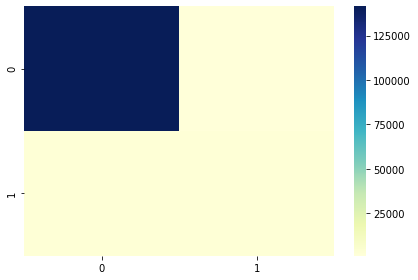

In [126]:
y_predictions = rf_classifier.predict(X_test)
accuracy_score = rf_classifier.score(X_test, y_test)
confusion_mat = plot_confusion_matrix(y_test, y_predictions, labels=[0,1])
print("Random Forest accuracy: " + str(accuracy_score))
prfs = precision_recall_fscore_support(y_test, y_predictions, average='binary')
print("Precision-Recall-Fscore-Support -> " + str(prfs))

In [ ]:
###

### Final Model
Alternative approach to handle imbalance data-set is to undersample majority class (non-fraud transactions)

We also experiment with bootsrapping/ensemble method like XGBoost to perform classification

In [293]:
# Undersampling with RandomSampler
X_train, X_test, y_train, y_test = split_dataset(pre_processed_df)

print("splitting over")

rus = RandomUnderSampler(return_indices=True)
X_undersample, y_undersample, id_undersample = rus.fit_sample(X_train, y_train)

print("Resample over")

splitting over
Resample over


In [294]:
xgb_classifier = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_classifier.fit(X_undersample, y_undersample)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

XGB accuracy: 0.7867036949232905
Confusion Marix: 
[[  3378   1717]
 [ 29773 112767]]
Precision-Recall-Fscore-Support -> (0.10189737866127718, 0.6630029440628067, 0.17664592375673271, None)


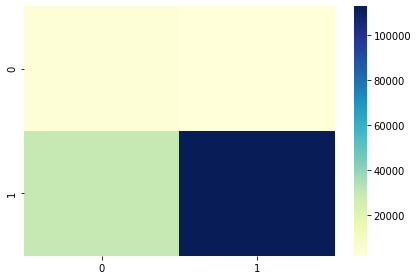

In [295]:
y_predictions = xgb_classifier.predict(X_test.values)
accuracy_score = xgb_classifier.score(X_test.values, y_test.values)
print("XGB accuracy: " + str(accuracy_score))
confusion_mat = plot_confusion_matrix(y_test, y_predictions)
prfs = precision_recall_fscore_support(y_test, y_predictions, average='binary')
print("Precision-Recall-Fscore-Support -> " + str(prfs))

Write your answer here

## Part 7 - Final Result

Report the rank, score, number of entries, for your highest rank. Include a snapshot of your best score on the leaderboard as confirmation. Be sure to provide a link to your Kaggle profile. Make sure to include a screenshot of your ranking. Make sure your profile includes your face and affiliation with SBU.

Kaggle Link: https://www.kaggle.com/parasquantshopper

Highest Rank: 5249

Score: 0.8294

Number of entries: 4

<img src="latestRankingImage.png">